Работа №25 <br>
Выполнить классификацию изображений на наборе notMNIST_small. <br> 
Используйте BN и коллбеки. <br>
Остальное по желанию


Loading necessary modules

In [ ]:
%reset -f 

import tensorflow as tf
import keras
from keras import models
from keras import optimizers
from keras import layers
from keras.metrics import AUC
from matplotlib import pyplot as plt
import numpy as np
import tarfile
import os, shutil
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Specifying data directory

In [ ]:
base_dir = './notMNIST_small'   # folder with notMNIST images

Looking at the number of images available

In [ ]:
folders = 'ABCDEFGHIJ'    # letters to be recognized
for folder in folders:
  print(f"Total {folder} images: {len(os.listdir(f'{base_dir}/{folder}'))}")    # how many images for each letter

Loading images and assigning label values (letters)

In [242]:
imgs = []
labels = []
for folder in folders:    # each folder with letters
  for img in os.listdir(base_dir + f"/{folder}"):   # each letter
    if img.endswith('.png'):    # png only
      try:    # trying to read 
        if not np.all(cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0] == cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0][0]):
            imgs.append(cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0])
            labels.append(folder)   # adding label for the class
      except:   # if an error is raised
        print(base_dir + f"/{folder}/{img}")     # name of picture not succeeded to be read
        continue
imgs = np.array(imgs).astype('float32')/255.    # scaling images to [0;1]

./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


Loaded image example:

(-0.5, 27.5, 27.5, -0.5)

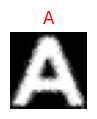

In [243]:
# image example with its label
plt.figure(figsize=(1,1))
plt.imshow(imgs[0], cmap = 'gray')
plt.title(labels[0], color = 'red')
plt.axis("off")

Shuffling images and their labels, accordingly

In [244]:
indices = np.arange(len(labels))    # data shuffle
np.random.shuffle(indices) # shuffled indices
imgs = imgs[indices] # rearranged images
labels = [labels[i] for i in indices] # rearranged labels

Looking what image is now on the 1st place

(-0.5, 27.5, 27.5, -0.5)

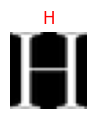

In [245]:
plt.figure(figsize=(1,1))
plt.imshow(imgs[0], cmap = 'gray')
plt.title(labels[0], color = 'red')
plt.axis("off")

Convert labels to categorical values by the one-hot encoding method (with preliminary transformation to numbers by LabelEncoder)

In [246]:
# Since the keras' method to_categorical can work with numerical data only, we'll first transform letters to numericals by use of LabelEncoder form sklearn:
encoder = LabelEncoder()
labels_num = encoder.fit_transform(labels)
new_labels = to_categorical(labels_num, num_classes=len(folders))
new_labels.shape

(18442, 10)

In [247]:
print("Images shape: ", imgs.shape)   # image dataset array  shape
print("Labels shape: ", new_labels.shape) # categorical labels array shape

Images shape:  (18442, 28, 28)
Labels shape:  (18442, 10)


Preparing train and test sub-samples:

In [248]:
# breaking down the dataset into train ans set sub-samples
test_imgs = imgs[:500]
test_labels = np.array(new_labels[:500])
train_imgs = imgs[500:]
train_labels = np.array(new_labels[500:])
print("Train images shape: ", train_imgs.shape)
print("Test images shape: ", test_imgs.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train images shape:  (17942, 28, 28)
Test images shape:  (500, 28, 28)
Train labels shape:  (17942, 10)
Test labels shape:  (500, 10)


Reshape the data to (num_samples, 28, 28, 1) for the 1st convolutional layer

In [249]:
X_train = train_imgs.reshape((train_imgs.shape[0], 28, 28, 1))
X_test = test_imgs.reshape((test_imgs.shape[0], 28, 28, 1))
y_train = train_labels
y_test = test_labels
print("Train images shape: ", X_train.shape)
print("Test images shape: ", X_test.shape)
print("Train labels shape: ", y_train.shape)
print("Test labels shape: ", y_test.shape)

Train images shape:  (17942, 28, 28, 1)
Test images shape:  (500, 28, 28, 1)
Train labels shape:  (17942, 10)
Test labels shape:  (500, 10)


Building a convolutional neural network model with augmentation, tf is used

In [250]:
# 3. Create the model
model = models.Sequential()

# data augmentation
model.add(layers.RandomZoom(0.3))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomTranslation(height_factor=0.2, width_factor=0.2))
model.add(layers.RandomContrast(0.2))

# model layers:
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(folders), activation='softmax'))

c:\Users\varaksa_yua\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Adding the callbacks

In [251]:
# 1. **Learning Rate Scheduling**:
# learning rate scheduling to adjust the learning rate during training
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# 2. **Early Stopping**:
# early stopping to stop training when the validation loss stops improving
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 3. **Model Checkpoint**:
# - Save the best model during training.
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

Compiling the model 

In [252]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Training the model with the added callbacks.

In [253]:
epochs = 100
batch_size = 32
model.fit(X_train, y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    validation_split = 0.2, 
                    callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4897 - loss: 1.5421 - val_accuracy: 0.7657 - val_loss: 0.8890 - learning_rate: 0.0010
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6949 - loss: 0.9341 - val_accuracy: 0.8663 - val_loss: 0.4858 - learning_rate: 0.0010
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7340 - loss: 0.8196 - val_accuracy: 0.8660 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7597 - loss: 0.7436 - val_accuracy: 0.8568 - val_loss: 0.4696 - learning_rate: 0.0010
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7778 - loss: 0.6868 - val_accuracy: 0.8657 - val_loss: 0.4536 - learning_rate: 0.0010
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7784 - loss: 0.6680 - val_accuracy: 0.8573 - val_loss: 0.4747 - learning_rate: 0.0010
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7891 - los

Evaluating the model

In [254]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss * 100:.2f}%')
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9134 - loss: 0.3478 
Test loss: 28.62%
Test accuracy: 91.60%


Making some predictions based on the test dataset

In [255]:
predictions = model.predict(X_test)
predicted_class_numbers = np.argmax(predictions, axis=1)
predicted_classes = [folders[i] for i in predicted_class_numbers]

# Display some predictions
for i in range(15):
    pr_class = predicted_classes[i]
    act_class = labels[i]
    print(f"Predicted: {pr_class}, Actual: {act_class}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicted: H, Actual: H
Predicted: J, Actual: J
Predicted: B, Actual: B
Predicted: H, Actual: H
Predicted: I, Actual: I
Predicted: D, Actual: I
Predicted: F, Actual: F
Predicted: A, Actual: A
Predicted: D, Actual: D
Predicted: J, Actual: J
Predicted: C, Actual: C
Predicted: F, Actual: F
Predicted: B, Actual: E
Predicted: F, Actual: F
Predicted: I, Actual: I


Let's draw some pictures from the test sample with their corresponding values predicted by the model:

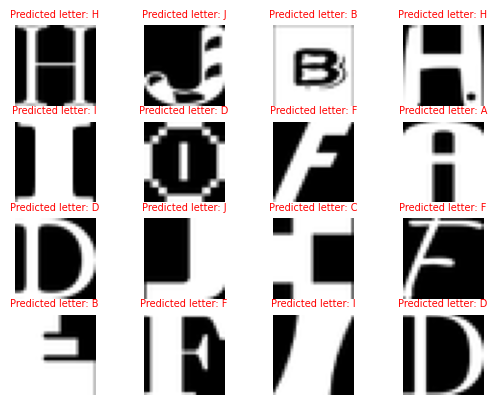

In [256]:
import matplotlib.pyplot as plt

for i in range(16):
    I = X_test[i,:,:,:]
    # Add the image to the figure
    plt.subplot(4, 4, i+1)  # 4 rows, 4 columns, i-th position
    plt.imshow(I, cmap='gray')  
    plt.axis('off')  # Hide the axis labels
    plt.title(f'Predicted letter: {predicted_classes[i]}', fontsize = 7, color = 'red') 
plt.show()

**Conclusions** 

A convolutional neural network was built in tf/keras for recognition of block letters from the dataset notMNIST <br>
Some data augmentation as well as the batch normalization was used for improving the performance of the model. <br>
Also the callbacks were used for improving the performance (adaptive learning rate), prevention of excessive iterations i.e. decreasing the learning time (early stopping), as well as saving the trained model (model checkpoint).

The recognition results on the test sample are the following: <br>
Batch size: 32  <br>
Epochs: 5, test accuracy 86.6%  <br>
Epochs: 20, test accuracy 88.20%  <br>
Epochs: 50, test accuracy 90.0%  <br>
Epochs: 100, test accuracy 91.60%  (in fact we had early stopping after 51st epoch) <br> 